In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../..')
from funcs.stats import get_stats, fit_lm
from funcs.xarray_tools import find_cor_ts
from funcs.plotting import map_grid_clean, add_text
from constants.colors import loc_colors

from taus import decorrelation_temporal_model

In [109]:
# fps = list(Path('/Users/rdcrlzh1/Documents/uavsar-coherence/uavsar').glob('*_tau.nc'))
fps = list(Path('/bsuhome/zacharykeskinen/scratch/coherence/uavsar').glob('*_tau.nc'))
dss = {fp.stem.replace('_v3_tau',''): xr.open_dataset(fp) for fp in fps}
df = pd.read_csv(Path('/bsuhome/zacharykeskinen/uavsar-coherence/data/snotel').joinpath('snotel_uavsar_diffs_v2.csv'))
df['swe_diff_daynorm'] = df.swe_diff / df.days

fig_dir = Path('/bsuhome/zacharykeskinen/uavsar-coherence/figures/polarization/snotel')

In [61]:
from itertools import combinations, product
copol = pd.DataFrame()
cross = pd.DataFrame()
id = 0
for snotel in df.snotel.unique():
    # print(snotel)
    for t1, t2 in product(df[df.snotel == snotel].t1.unique(), df[df.snotel == snotel].t2.unique()):
        sub = df[(df.snotel == snotel) & (df.t1 == t1) & (df.t2 == t2)]
        if len(sub) == 0: continue

        # co polarization example (swe change, total swe, temp, temp_diff)
        if sub.pol.str.contains('HH').any() and sub.pol.str.contains('VV').any():
            for col in ['days', 'temp_diff', 'swe_diff', 'sd_diff', 'swe_t2', 'inc', 'tree_perc', 'swe_diff_daynorm']:
                copol.loc[id, col] = sub.iloc[0][col]
            copol.loc[id, 'copol_diff'] = sub.loc[sub.pol == 'VV', 'cor'].values[0] - sub.loc[sub.pol == 'HH', 'cor'].values[0]
            copol.loc[id, 'copol_diff_perc'] = (sub.loc[sub.pol == 'VV', 'cor'].values[0] - sub.loc[sub.pol == 'HH', 'cor'].values[0]) / sub.loc[(sub.pol == 'VV') | (sub.pol == 'HH'), 'cor'].mean()

            if sub.iloc[0]['sd_diff'] != 0: copol.loc[id, 'snow_accumulation_density'] = sub.iloc[0]['swe_diff'] / sub.iloc[0]['sd_diff'] * 997
            else: copol.loc[id, 'snow_accumulation_density'] = np.nan
            copol.loc[id, 'mean_temp'] = sub[['temp_t1', 'temp_t2']].mean(axis = 1).mean()
            copol.loc[id, 'max_temp'] = sub[['temp_t1', 'temp_t2']].max(axis = 1).max()
            copol.loc[id, 'VV_cor'] = sub.loc[sub.pol == 'VV', 'cor'].values[0]
            copol.loc[id, 'HH_cor'] = sub.loc[sub.pol == 'HH', 'cor'].values[0]
        # cross polarization example (swe change, total swe, temp, temp_diff)
        if sub.pol.str.contains('VH').any() and sub.pol.str.contains('HV').any():
            for col in ['days', 'temp_diff', 'swe_diff', 'sd_diff', 'swe_t2', 'inc', 'tree_perc', 'swe_diff_daynorm']:
                cross.loc[id, col] = sub.iloc[0][col]
            cross.loc[id, 'cross_diff'] = sub.loc[sub.pol == 'HV', 'cor'].values[0] - sub.loc[sub.pol == 'VH', 'cor'].values[0]
            cross.loc[id, 'cross_diff_perc'] = (sub.loc[sub.pol == 'HV', 'cor'].values[0] - sub.loc[sub.pol == 'VH', 'cor'].values[0]) / sub.loc[(sub.pol == 'HV') | (sub.pol == 'VH'), 'cor'].mean()

            if sub.iloc[0]['sd_diff'] != 0: cross.loc[id, 'snow_accumulation_density'] = sub.iloc[0]['swe_diff'] / sub.iloc[0]['sd_diff'] * 997
            else: cross.loc[id, 'snow_accumulation_density'] = np.nan
            cross.loc[id, 'mean_temp'] = sub[['temp_t1', 'temp_t2']].mean(axis = 1).mean()
            cross.loc[id, 'max_temp'] = sub[['temp_t1', 'temp_t2']].max(axis = 1).max()
            cross.loc[id, 'VH_cor'] = sub.loc[sub.pol == 'VH', 'cor'].values[0]
            cross.loc[id, 'HV_cor'] = sub.loc[sub.pol == 'HV', 'cor'].values[0]
        id += 1


# Co pol analysis

In [88]:
def plot_snotel_scatter(ax, col, xlabel):
    if col == 'days': plot_df = copol[copol.days < 60]
    else: plot_df = copol
    plot_df.plot.scatter(x = col, y ='copol_diff', ax = ax)
    rmse, r, n = get_stats(plot_df[col], plot_df['copol_diff'])
    add_text(f'r: {r:.2f}. n: {n:.0f}', ax, 'upper left')
    r_sq, intercept, coefficient = fit_lm(plot_df[col], plot_df['copol_diff'], clean = True)
    xs = np.linspace(plot_df[col].min(), plot_df[col].max(), 100)
    ax.plot(xs, intercept + xs * coefficient, linestyle = 'dashed', color = 'red', label = 'Linear Model')
    # ax.axis('equal')
    ax.set_ylim(-0.12, 0.12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('VV - HH Coherence Difference []')
    ax.axhline(0, label = 'No Difference', color = 'k', linestyle = 'dotted')

In [134]:
for col in copol.columns:
    if abs(get_stats(copol[col], copol['copol_diff'])[1]) > 0.1:
        print(col)
        print(get_stats(copol[col], copol['copol_diff'])[1])

swe_t2
0.16978529982862747
tree_perc
-0.3903804922250246
copol_diff
1.0
copol_diff_perc
0.9799861950336692
mean_temp
0.24242966355842305
max_temp
0.2166076257703875
VV_cor
0.29627760559190575


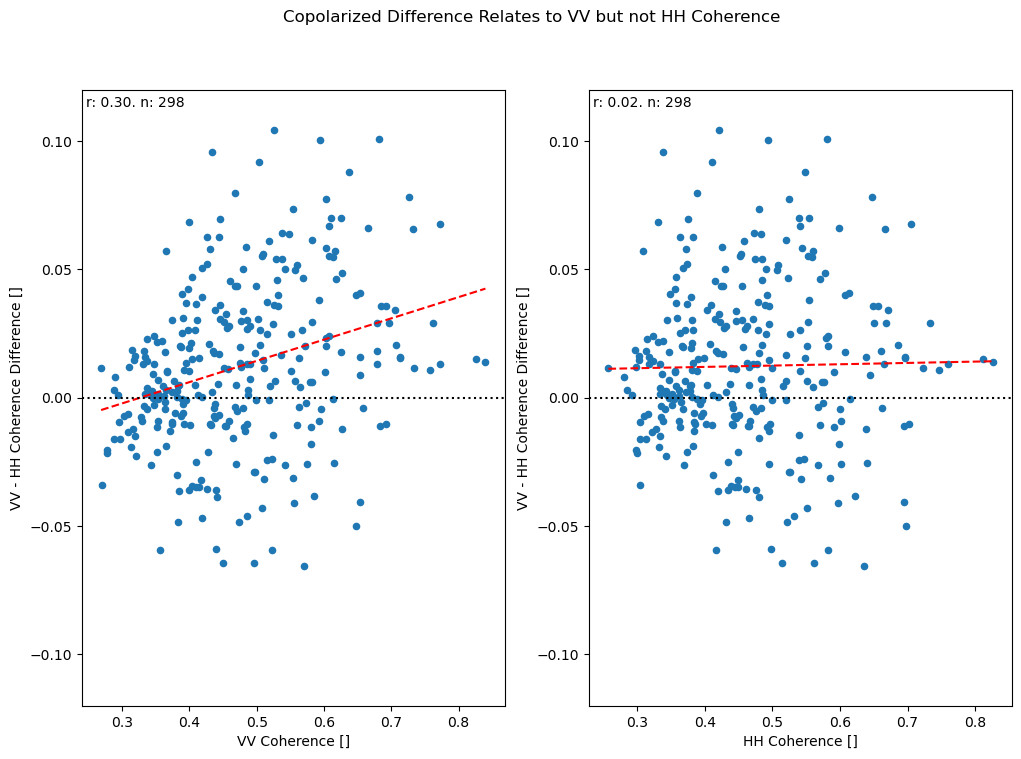

In [110]:
fig, axes = plt.subplots(1, 2, figsize = (12, 8))

plot_snotel_scatter(axes[0], 'VV_cor', 'VV Coherence []')
plot_snotel_scatter(axes[1], 'HH_cor', 'HH Coherence []')

plt.suptitle('Copolarized Difference Relates to VV but not HH Coherence')
plt.savefig(fig_dir.joinpath('copol_vv_hh_compare.png'))

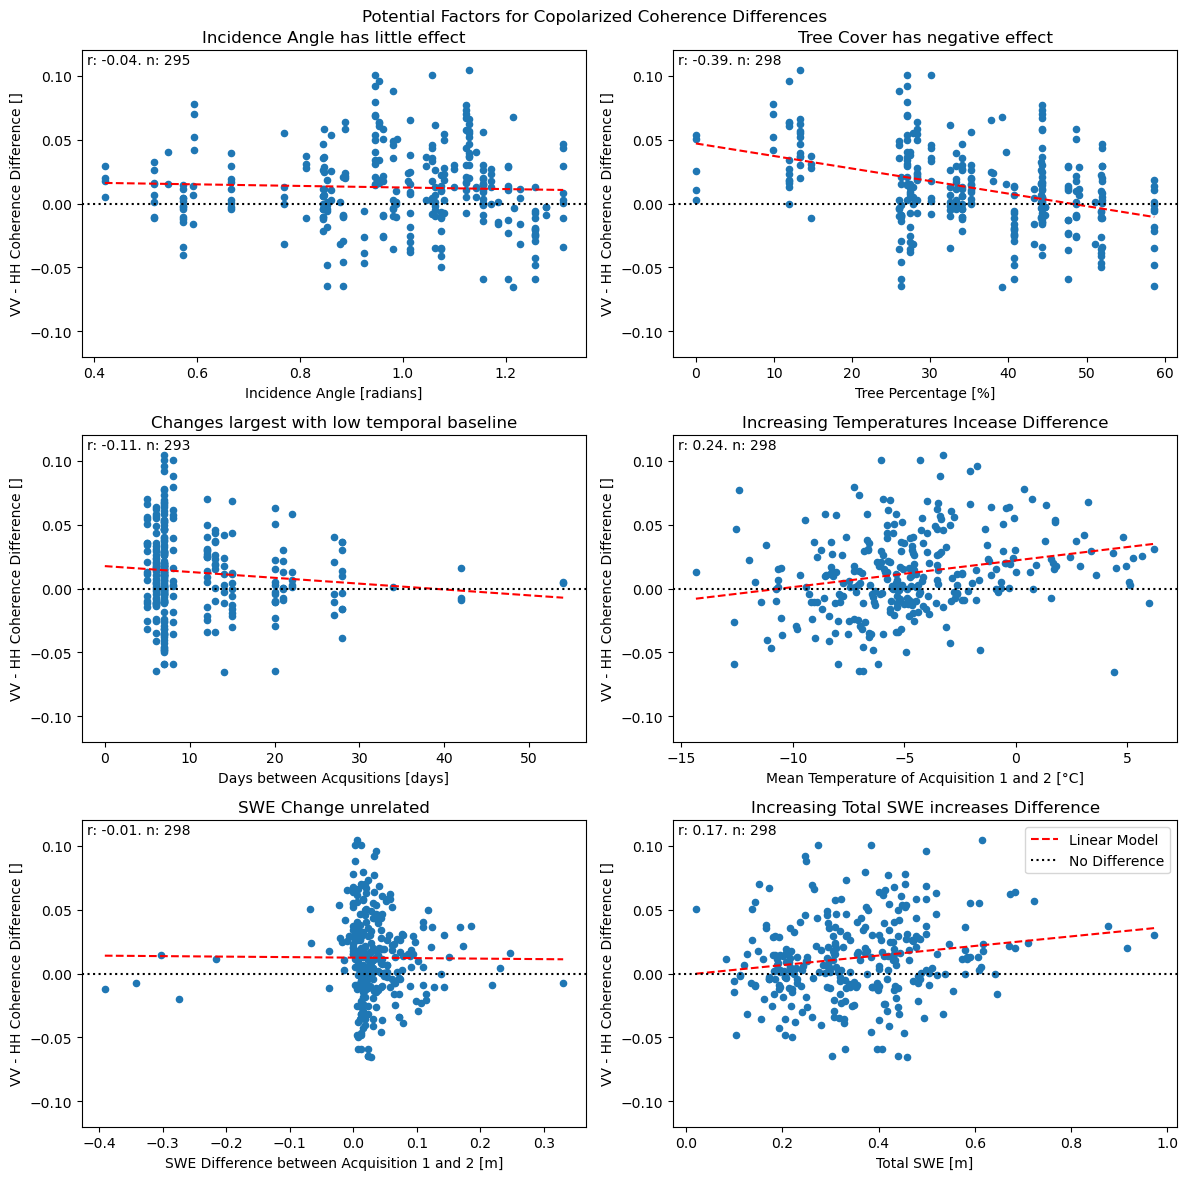

In [111]:
fig, axes = plt.subplots(3, 2, figsize = (12, 12))

plot_snotel_scatter(axes[0,0], 'inc', 'Incidence Angle [radians]')
plot_snotel_scatter(axes[0,1], 'tree_perc', 'Tree Percentage [%]')
plot_snotel_scatter(axes[1, 0], 'days', 'Days between Acqusitions [days]')

plot_snotel_scatter(axes[2, 1], 'swe_t2', 'Total SWE [m]')
plot_snotel_scatter(axes[1, 1], 'mean_temp', 'Mean Temperature of Acquisition 1 and 2 [°C]')
plot_snotel_scatter(axes[2, 0], 'swe_diff', 'SWE Difference between Acquisition 1 and 2 [m]')

plt.suptitle('Potential Factors for Copolarized Coherence Differences')

for ax, title in zip(axes.ravel(), ['Incidence Angle has little effect', 'Tree Cover has negative effect', 'Changes largest with low temporal baseline', 'Increasing Temperatures Increase Difference', 'SWE Change unrelated', 'Increasing Total SWE increases Difference']):
    ax.set_title(title)

axes[2,1].legend()
plt.tight_layout()
plt.savefig(fig_dir.joinpath('copol_factors.png'))

# cross polarized snotels quantiative

In [56]:
for col in cross.columns:
    if abs(get_stats(cross[col], cross['cross_diff'])[1]) > 0.1:
        print(col)
        print(get_stats(cross[col], cross['cross_diff'])[1])

inc
0.34619676466369254
tree_perc
0.17406205134445227
cross_diff
0.9999999999999999
cross_diff_perc
0.9744794516014714
mean_temp
-0.20338739722570173
max_temp
-0.1889754087772637
VH_cor
0.11138215232571638


In [97]:
def plot_cross_snotel_scatter(ax, col, xlabel):
    if col == 'days': plot_df = cross[cross.days < 60]
    else: plot_df = cross

    plot_df.plot.scatter(x = col, y ='cross_diff', ax = ax)
    rmse, r, n = get_stats(plot_df[col], plot_df['cross_diff'])
    add_text(f'r: {r:.2f}. n: {n:.0f}', ax, 'upper left')
    r_sq, intercept, coefficient = fit_lm(plot_df[col], plot_df['cross_diff'], clean = True)
    xs = np.linspace(plot_df[col].min(), plot_df[col].max(), 100)
    ax.plot(xs, intercept + xs * coefficient, linestyle = 'dashed', color = 'red', label = 'Linear Model')
    # ax.axis('equal')
    ax.set_ylim(-0.12, 0.12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('HV - HV Coherence Difference []')
    ax.axhline(0, label = 'No Difference', color = 'k', linestyle = 'dotted')

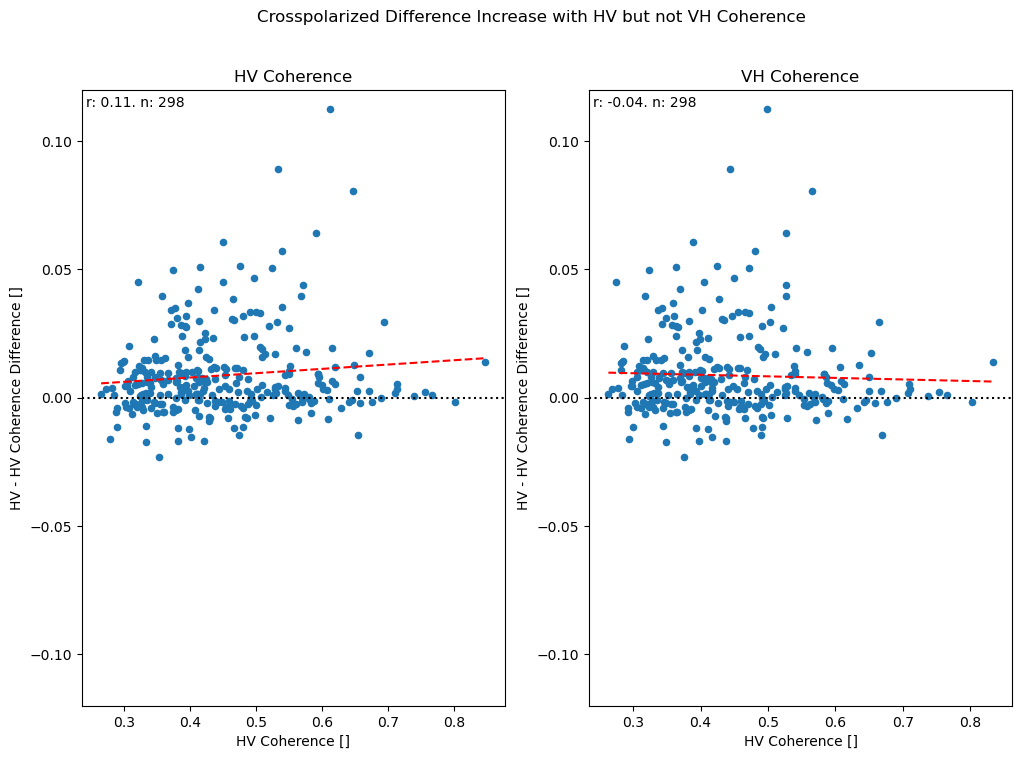

In [113]:
fig, axes = plt.subplots(1, 2, figsize = (12, 8))

plot_cross_snotel_scatter(axes[0], 'HV_cor', 'HV Coherence []')
plot_cross_snotel_scatter(axes[1], 'VH_cor', 'HV Coherence []')

plt.suptitle('Crosspolarized Difference Increase with HV but not VH Coherence')
for ax, title in zip(axes, ['HV Coherence', 'VH Coherence']): ax.set_title(title)
plt.savefig(fig_dir.joinpath('cross_VH_HV.png'))

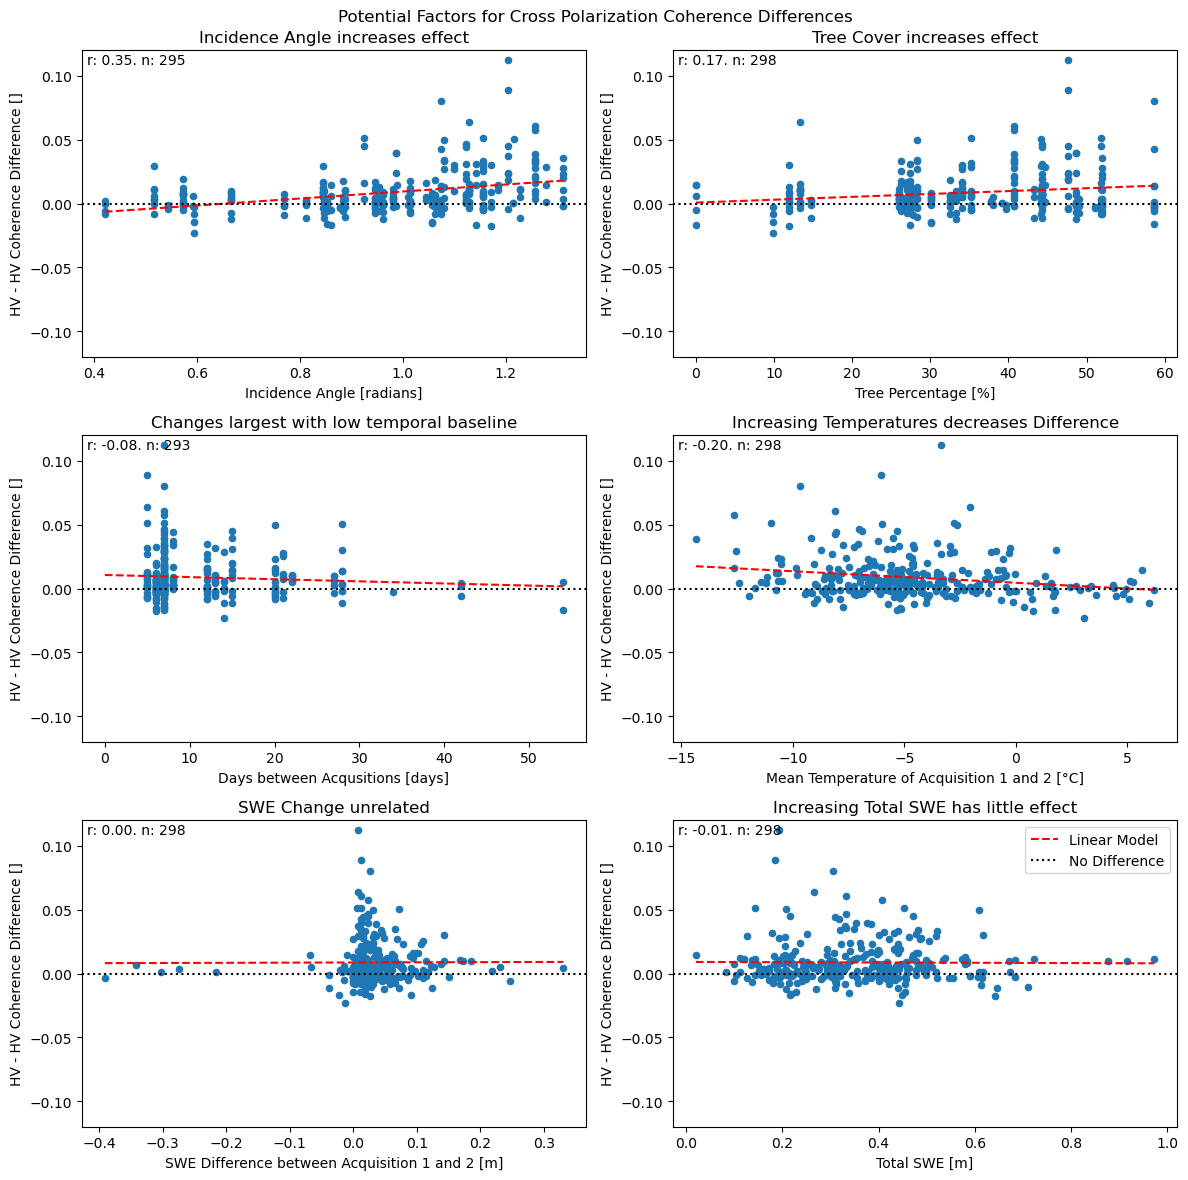

In [114]:
fig, axes = plt.subplots(3, 2, figsize = (12, 12))

plot_cross_snotel_scatter(axes[0,0], 'inc', 'Incidence Angle [radians]')
plot_cross_snotel_scatter(axes[0,1], 'tree_perc', 'Tree Percentage [%]')
plot_cross_snotel_scatter(axes[1, 0], 'days', 'Days between Acqusitions [days]')

plot_cross_snotel_scatter(axes[2, 1], 'swe_t2', 'Total SWE [m]')
plot_cross_snotel_scatter(axes[1, 1], 'mean_temp', 'Mean Temperature of Acquisition 1 and 2 [°C]')
plot_cross_snotel_scatter(axes[2, 0], 'swe_diff', 'SWE Difference between Acquisition 1 and 2 [m]')

plt.suptitle('Potential Factors for Cross Polarization Coherence Differences')

for ax, title in zip(axes.ravel(), ['Incidence Angle increases effect', 'Tree Cover increases effect', 'Changes largest with low temporal baseline', 'Increasing Temperatures decreases Difference', 'SWE Change unrelated', 'Increasing Total SWE has little effect']):
    ax.set_title(title)

axes[2,1].legend()
plt.tight_layout()
plt.savefig(fig_dir.joinpath('cross_factors.png'))